# Exercise 12

## Analyze how travelers expressed their feelings on Twitter

A sentiment analysis job about the problems of each major U.S. airline. 
Twitter data was scraped from February of 2015 and contributors were 
asked to first classify positive, negative, and neutral tweets, followed
by categorizing negative reasons (such as "late flight" or "rude service").

In [1]:
import pandas as pd
import numpy as np

%matplotlib inline
import matplotlib.pyplot as plt

# read the data and set the datetime as the index
tweets = pd.read_csv('https://github.com/albahnsen/PracticalMachineLearningClass/raw/master/datasets/Tweets.zip', index_col=0)

tweets.head()

,airline_sentiment,airline_sentiment_confidence,negativereason,negativereason_confidence,airline,airline_sentiment_gold,name,negativereason_gold,retweet_count,text,tweet_coord,tweet_created,tweet_location,user_timezone
tweet_id,,,,,,,,,,,,,,
570306133677760513,neutral,1.0000,NaN,NaN,Virgin America,NaN,cairdin,NaN,0,@VirginAmerica What @dhepburn said.,NaN,2015-02-24 11:35:52 -0800,NaN,Eastern Time (US & Canada)
570301130888122368,positive,0.3486,NaN,0.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica plus you've added commercials t...,NaN,2015-02-24 11:15:59 -0800,NaN,Pacific Time (US & Canada)
570301083672813571,neutral,0.6837,NaN,NaN,Virgin America,NaN,yvonnalynn,NaN,0,@VirginAmerica I didn't today... Must mean I n...,NaN,2015-02-24 11:15:48 -0800,Lets Play,Central Time (US & Canada)
570301031407624196,negative,1.0000,Bad Flight,0.7033,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica it's really aggressive to blast...,NaN,2015-02-24 11:15:36 -0800,NaN,Pacific Time (US & Canada)
570300817074462722,negative,1.0000,Can't Tell,1.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica and it's a really big bad thing...,NaN,2015-02-24 11:14:45 -0800,NaN,Pacific Time (US & Canada)


In [2]:
tweets.shape

(14640, 14)

### Proportion of tweets with each sentiment

In [3]:
tweets['airline_sentiment'].value_counts()

negative    9178
neutral     3099
positive    2363
Name: airline_sentiment, dtype: int64

### Proportion of tweets per airline


In [4]:
tweets['airline'].value_counts()

United            3822
US Airways        2913
American          2759
Southwest         2420
Delta             2222
Virgin America     504
Name: airline, dtype: int64

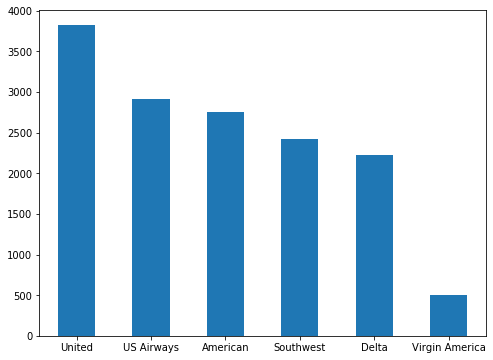

In [5]:
pd.Series(tweets["airline"]).value_counts().plot(kind = "bar",figsize=(8,6),rot = 0)

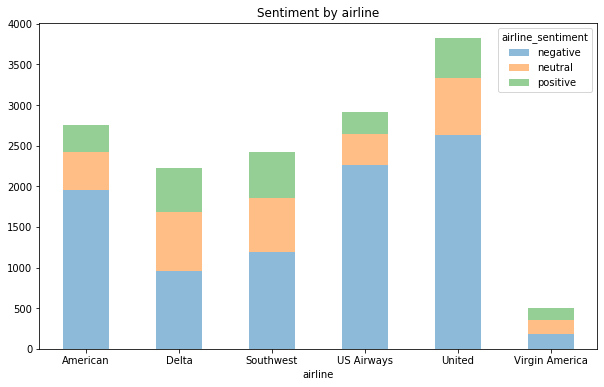

In [6]:
pd.crosstab(index = tweets["airline"],columns = tweets["airline_sentiment"]).plot(kind='bar',figsize=(10, 6),alpha=0.5,rot=0,stacked=True,title="Sentiment by airline")

# Exercise 12.1 

Predict the sentiment using CountVectorizer

use Random Forest classifier

In [7]:
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier as RFC
from nltk.stem.snowball import SnowballStemmer
from nltk.stem import WordNetLemmatizer
import numpy as np

In [8]:
X = tweets['text']
y = tweets['airline_sentiment'].map({'negative':-1,'neutral':0,'positive':1})

In [9]:
vect = CountVectorizer()
X_dtm = vect.fit_transform(X)

In [10]:
temp=X_dtm.todense()

In [11]:
vect.vocabulary_

{'virginamerica': 14273,
 'what': 14551,
 'dhepburn': 4804,
 'said': 11646,
 'plus': 10438,
 'you': 14944,
 've': 14193,
 'added': 1965,
 'commercials': 4030,
 'to': 13326,
 'the': 13120,
 'experience': 5665,
 'tacky': 12925,
 'didn': 4821,
 'today': 13330,
 'must': 9234,
 'mean': 8837,
 'need': 9375,
 'take': 12941,
 'another': 2331,
 'trip': 13509,
 'it': 7685,
 'really': 11020,
 'aggressive': 2054,
 'blast': 3070,
 'obnoxious': 9726,
 'entertainment': 5455,
 'in': 7381,
 'your': 14953,
 'guests': 6733,
 'faces': 5740,
 'amp': 2263,
 'they': 13167,
 'have': 6868,
 'little': 8392,
 'recourse': 11078,
 'and': 2281,
 'big': 3007,
 'bad': 2746,
 'thing': 13176,
 'about': 1862,
 'seriously': 11914,
 'would': 14778,
 'pay': 10175,
 '30': 761,
 'flight': 6004,
 'for': 6157,
 'seats': 11832,
 'that': 13115,
 'this': 13188,
 'playing': 10403,
 'only': 9836,
 'flying': 6101,
 'va': 14145,
 'yes': 14922,
 'nearly': 9371,
 'every': 5572,
 'time': 13270,
 'fly': 6086,
 'vx': 14345,
 'ear': 5238,


In [12]:
temp

matrix([[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]], dtype=int64)

In [13]:
data = pd.DataFrame(temp, columns=vect.get_feature_names())

In [14]:
print(vect.get_feature_names()[500:700])

['202', '2020', '2022', '2023', '203', '2031', '2034', '2046', '2053', '206', '2062', '2063', '2065', '2066', '2069', '2070', '2078', '2086', '209', '20feb15', '20hrs', '20k', '20l', '20min', '20mins', '20minute', '20minutes', '20pm', '20th', '20x15', '20years', '20yr', '21', '210', '2100', '2102', '210pm', '211', '2118', '2119', '211pilot', '2120', '2133', '2139', '214', '214i0rtih4', '2155', '2160', '2168', '218', '21feb15', '21l', '21mbps', '21p', '21st', '22', '2202', '2208', '2210', '2214', '2218', '2222', '2224', '223', '2238', '2244', '2247', '2251', '2258', '226', '2275', '2284', '2293', '2298', '22ipgeicsm', '22nd', '23', '2301', '2302', '230am', '2312', '2321', '2324', '2330', '2334', '2339', '2348', '235', '2350', '236', '2373', '2386', '2390', '2396', '23oct', '23rd', '23sep', '24', '240', '2401', '240minute', '2413', '2416', '2417', '2424', '2440', '245', '2463', '2464', '2470', '2488', '249', '2495', '2498', '24h', '24hours', '24hr', '24hrs', '24th', '25', '250', '250k', 

In [15]:
data

,00,000,000114,000419,000ft,000lbs,0011,0016,00a,00am,...,zrh_airport,zsdgzydnde,zsuztnaijq,ztrdwv0n4l,zukes,zurich,zv2pt6trk9,zv6cfpohl5,zvfmxnuelj,zzps5ywve2
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14635,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
14636,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
14637,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
14638,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [16]:
mdl1 = RFC(n_estimators=10, max_depth=50)
print(np.mean(cross_val_score(mdl1, data, y, cv=4)))

0.6576502732240437


# Exercise 12.2 

Remove stopwords, then predict the sentiment using CountVectorizer.

use Random Forest classifier

In [50]:
vect = CountVectorizer(stop_words='english')
X_dtm = vect.fit_transform(X)
temp = X_dtm.todense()
data = pd.DataFrame(temp, columns=vect.get_feature_names())
mdl = RFC(n_estimators=10, max_depth=50)
print(np.mean(cross_val_score(mdl, data, y, cv=10)))

0.6663934426229507


# Exercise 12.3

Increase n_grams size (with and without stopwords),  then predict the sentiment using CountVectorizer

use Random Forest classifier

In [ ]:
vect = CountVectorizer(ngram_range=(1, 2))
X_dtm = vect.fit_transform(X)
temp = X_dtm.todense()
data = pd.DataFrame(temp, columns=vect.get_feature_names())
mdl = RFC(n_estimators=10, max_depth=50)
print(np.mean(cross_val_score(mdl, data, y, cv=3)))

In [55]:
vect = CountVectorizer(stop_words='english', ngram_range=(1, 2))
X_dtm = vect.fit_transform(X)
temp = X_dtm.todense()
data = pd.DataFrame(temp, columns=vec.get_feature_names())
mdl = RFC(n_estimators=10, max_depth=50)
print(np.mean(cross_val_score(mdl, data, y, cv=3)))

MemoryError: Unable to allocate 9.82 GiB for an array with shape (13176, 100073) and data type int64

# Exercise 12.4

Predict the sentiment using TfidfVectorizer.

use Random Forest classifier

In [ ]:
vect = TfidfVectorizer()
data = pd.DataFrame(vect.fit_transform(X).toarray(), columns=vect.get_feature_names())
mdl = RFC(n_estimators=10, max_depth=50)
print(np.mean(cross_val_score(mdl, data, y, cv=10)))